In [5]:
from typing import Union
import datasets as dt
import models.SpinalNet as snet # needs images.to("cuda")
import models.CapsuleNetwork as cnet
from torch.utils.data import DataLoader
from torch import Tensor
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
from collections import Counter

device = "cuda"

# Same-sized input
dataset = dt.get_historical_dataset("raw")
raw_loader = DataLoader(dataset, 128, num_workers=4, shuffle=True)
idx_to_class = {idx: cls for cls, idx in dataset.class_to_idx.items()}

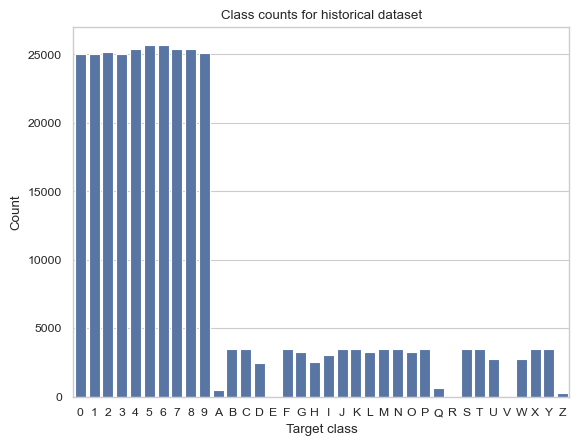

In [8]:
import seaborn as sns
sns.set_theme("paper", "whitegrid")

classes = dict(Counter(dataset.targets))
classes = {idx_to_class[idx]: count for idx, count in classes.items()}

plot = sns.barplot(classes)
plot.set_title("Class counts for historical dataset")
plot.set_xlabel("Target class")
plot.set_ylabel("Count")
plt.savefig("./imgs/historical_count.pdf")

In [ ]:
model = cnet.get_model().to(device)
model.eval()

n_correct_chars = np.zeros(len(dataset.classes))
count_chars = np.zeros(len(dataset.classes))

remapping = {36: 10, 37: 11, 38: 13, 39: 14, 40: 15, 41: 16, 42: 17, 43: 23, 44: 26, 45: 27, 46: 29}
logic = lambda x: remapping.get(x, x)
remapper = torch.vmap(logic)

pbar = tqdm(raw_loader)
for images, labels in pbar:
    with torch.no_grad():
        preds: Union[tuple[Tensor, Tensor, Tensor], Tensor]  = model(images.to(device))
        if isinstance(preds, tuple):
            preds = preds[2].to("cpu")
        else:
            preds = torch.max(preds.data, 1)[1].to("cpu")

        correct_labels = remapper(preds) == labels

        np.add.at(n_correct_chars, labels[correct_labels], 1)
        np.add.at(count_chars, labels, 1)
        pbar.set_description(f"Partial accuracy: {np.sum(n_correct_chars) / np.sum(count_chars):.5f}")

char_accuracy = n_correct_chars / count_chars

  0%|          | 0/2497 [00:00<?, ?it/s]

In [ ]:
character_accuracy = {}

for idx, acc in enumerate(char_accuracy):
    character_accuracy[idx_to_class[idx]] = acc

character_accuracy

{'0': 0.009225239616613418,
 '1': 3.999680025597952e-05,
 '2': 0.003101145038167939,
 '3': 0.0003992175336340772,
 '4': 0.00015743073047858942,
 '5': 0.006578691268636382,
 '6': 0.0004279156617132187,
 '7': 0.0007102552973207592,
 '8': 0.013168269988960733,
 '9': 0.0003982952961325527,
 'A': 0.024,
 'B': 0.33057142857142857,
 'C': 0.00028571428571428574,
 'D': 0.0,
 'E': 0.0,
 'F': 0.0,
 'G': 0.0003076923076923077,
 'H': 0.0,
 'I': 0.0,
 'J': 0.0,
 'K': 0.00028571428571428574,
 'L': 0.0018461538461538461,
 'M': 0.008,
 'N': 0.030285714285714287,
 'O': 0.0003074085459575776,
 'P': 0.00028571428571428574,
 'Q': 0.0,
 'R': 0.0,
 'S': 0.0,
 'T': 0.0005714285714285715,
 'U': 0.0018181818181818182,
 'V': 0.0,
 'W': 0.0,
 'X': 0.0,
 'Y': 0.0,
 'Z': 0.0}

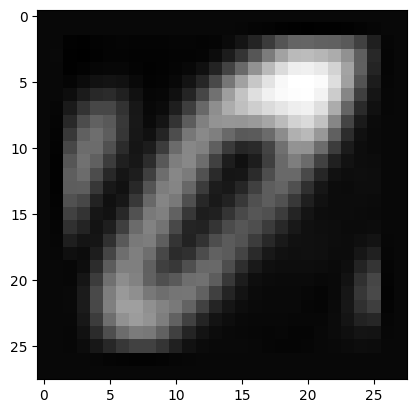

tensor([[44, 41, 44, 41, 41,  6, 16, 14, 10, 38, 26, 14, 16, 33, 18, 10]])

In [37]:
img = dataset.__getitem__(5)[0]

plt.imshow(img.permute(1, 2, 0).numpy(), cmap="grey")
plt.show()

res:Tensor = model(torch.unsqueeze(img, 0))[0]
res.argmax(axis=1)

In [22]:
idx_to_class = {idx: cls for cls, idx in dt.EMNIST_TEST.class_to_idx.items()}

#pred_labels = np.vectorize(idx_to_class.get)(preds)
#actual_labels = np.vectorize(idx_to_class.get)(labels)
print(sum(torch.max(preds.data, 1)[1].cpu() == labels) / len(labels))

tensor(0.5078)
